<a href="https://colab.research.google.com/github/MinHyeokJeong/python_ex/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install alibi_detect==0.5.0

In [46]:
!pip install Image

In [81]:
import os
os.environ['KAGGLE_USERNAME'] = 'minhyeokjeong'
os.environ['KAGGLE_KEY'] = 'e0ff1ecb7a0ce0740c57c3879bec690c'

In [82]:
!kaggle datasets download -d arunrk7/surface-crack-detection

surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip -q surface-crack-detection.zip

In [83]:
#Import Packages
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Dense,Layer,Reshape,InputLayer
#from alibi_detect.model.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score,plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob


In [84]:

#Negative : normal images
#Positive : crack inmages

#Load Normal Images
img_list = glob('Negative/*.jpg');
train_img_list, val_img_list = train_test_split(img_list,test_size=0.1, random_state=2021)
def img_to_np(fpaths, resize=True):
    img_array=[]
    for fname in fpaths:
        try:
            img=Image.open(fname).convert('RGB')
            if(resize):img=img.resize((64,64))
            img_array.append(np.asarray(img))
        except:
            continue
    images = np.array(img_array)
    return images

#데이터 셋을 1000으로 했지만 만드는거에 따라서 학습시간이 달라짐
x_train = img_to_np(train_img_list[:1000])
x_train = x_train.astype(np.float32)/255.

x_val = img_to_np(val_img_list[:32])
x_val = x_val.astype(np.float32)/255.

print(x_train.shape)
print(x_val.shape)

(1000, 64, 64, 3)
(32, 64, 64, 3)


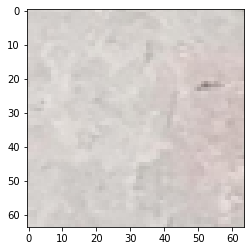

In [85]:
plt.imshow(x_train[0])

In [86]:
#Bulid Model
#latent 차원 1024 설정
latent_dim =1024

#keras.Sequential에서 만들어줌
#가로 64 세로 64 채널 3
encoder_net=tf.keras.Sequential([
    InputLayer(input_shape=(64,64,3)),
    #converution을 사용하고 activation = relu를 사용하여 세개를 쌓아줌
    Conv2D(64,4,strides=2,padding='same',activation=tf.nn.relu),
    Conv2D(128,4,strides=2,padding='same',activation=tf.nn.relu),
    Conv2D(512,4,strides=2,padding='same',activation=tf.nn.relu)
])

#decorder로 차원을 축소, input = latent_dim을 넣어줌
decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4*4*128),
    #3D형태로 만들어줌
    Reshape(target_shape=(4,4,128)),
    #차원을 strides 배만큼 늘려줌, sigmoid = 0~1사이 이미지 출력
    Conv2DTranspose(256,4, strides=2,padding='same',activation=tf.nn.relu),
    Conv2DTranspose(64,4, strides=2,padding='same',activation=tf.nn.relu),
    Conv2DTranspose(32,4, strides=2,padding='same',activation=tf.nn.relu),
    Conv2DTranspose(3,4, strides=2,padding='same',activation='sigmoid')
])

od = OutlierVAE(
    #instance_score < 0.005보다 작으면 정상 크면 비정상
    threshold=.003,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [95]:
od.fit(
    x_train,
    epochs=30,
    verbose=True
)

16/16 [=] - 42s 3s/step - loss: -21987.3514


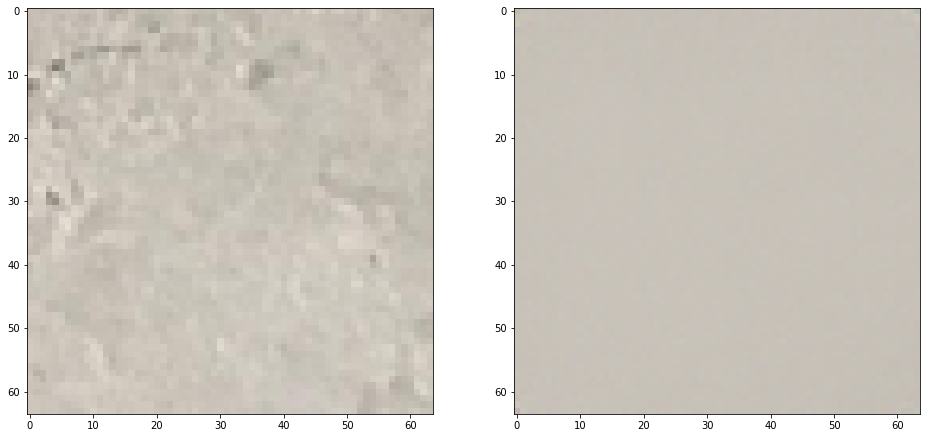

In [96]:
#Reconstruct Training Image
idx =12
x = x_train[idx].reshape(1,64,64,3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1,2,figsize=(16,10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())


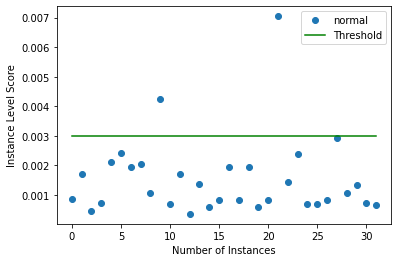

In [97]:
#Validation
#od.predict = 예측
od_preds = od.predict(
    x_val,
    #픽셀의 값을 뺀거
    outlier_type = 'instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels =['normal','outlier']
#애니메이션 이미지 32개로 지정했기에 32개의점이 나옴 = 픽셀의 차이
plot_instance_score(od_preds, target, labels, od.threshold)


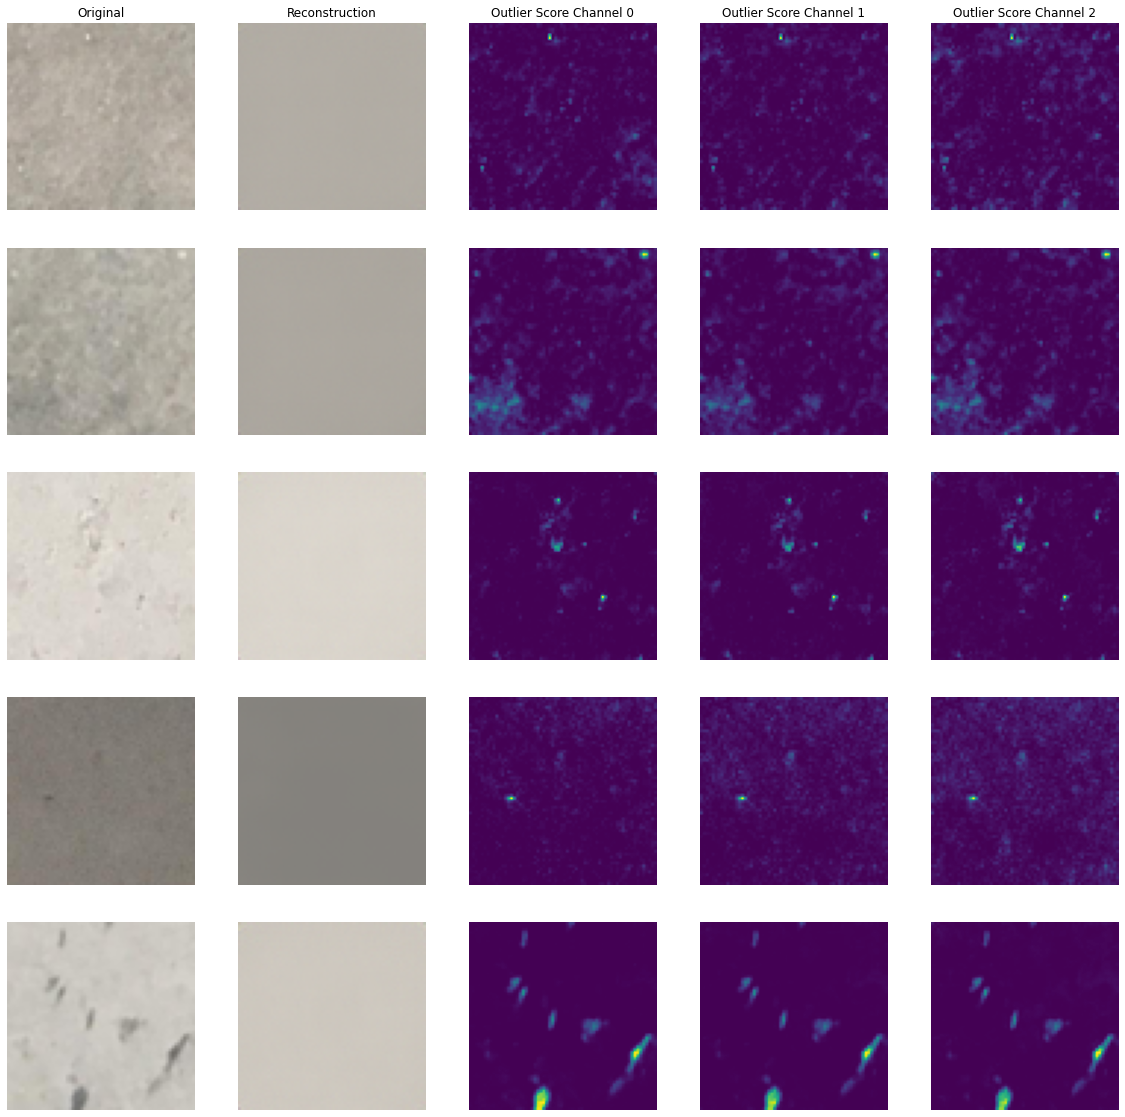

In [98]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)


(32, 64, 64, 3)


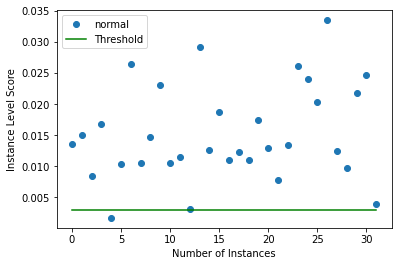

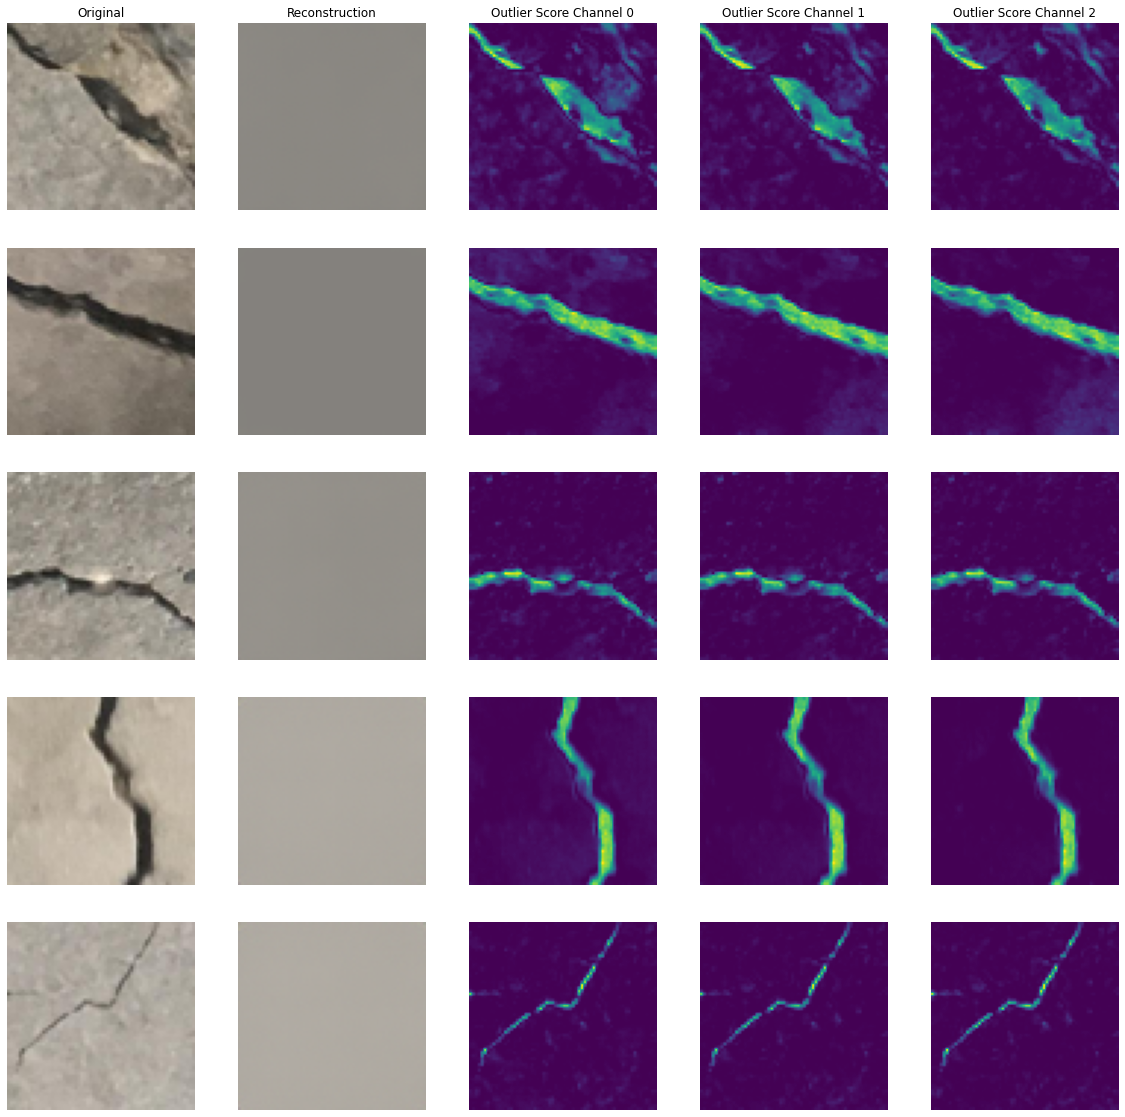

In [99]:
#Test with Creak Images

test_img_list = glob('Positive/*.jpg')
x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32)/255.

print(x_test.shape)

od_preds =od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal','outlier']
plot_instance_score(od_preds,target,labels,od.threshold)

x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)